In [65]:
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt
import os


def imshow(img, ax=None):
    if img is None:
        return
    if ax is None:
        if img.ndim == 2:
            disp = cv2.cvtColor(cv2.convertScaleAbs(img), cv2.COLOR_GRAY2BGR)
        else:
            disp = cv2.convertScaleAbs(img)
        ret, encoded = cv2.imencode(".jpg", disp)
        display(Image(encoded))
    else:
        if img.ndim == 3:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            ax.imshow(img, cmap="gray")
        ax.axis("off")


def save_image(path, filename, img):
    # use os.path.join for cross-platform paths
    cv2.imwrite(os.path.join(path, filename), img)


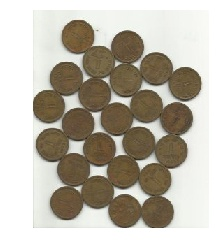

In [66]:
# Update the path if your image is located elsewhere
filename = 'coins.png'
image_path = f'images/{filename}'
outputs_folder = f'outputs/{filename.split(".")[0]}'
os.makedirs(outputs_folder, exist_ok=True)

img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f'Input image not found at {image_path}')
imshow(img)
save_image(outputs_folder, '01_original.png', img)


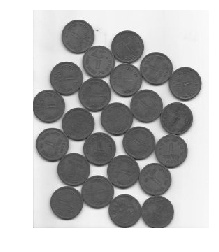

In [67]:
# Grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(gray)
save_image(outputs_folder, '02_grayscale.png', gray)

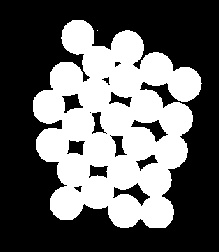

In [68]:
# Threshold (Otsu, inverse)
ret, bin_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
imshow(bin_img)
save_image(outputs_folder, '03_threshold.png', bin_img)

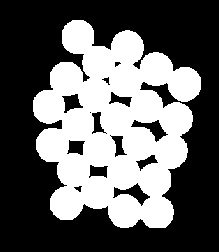

In [69]:
# Morphological opening to remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=2)
imshow(bin_img)
save_image(outputs_folder, '04_morphological_opening.png', bin_img)

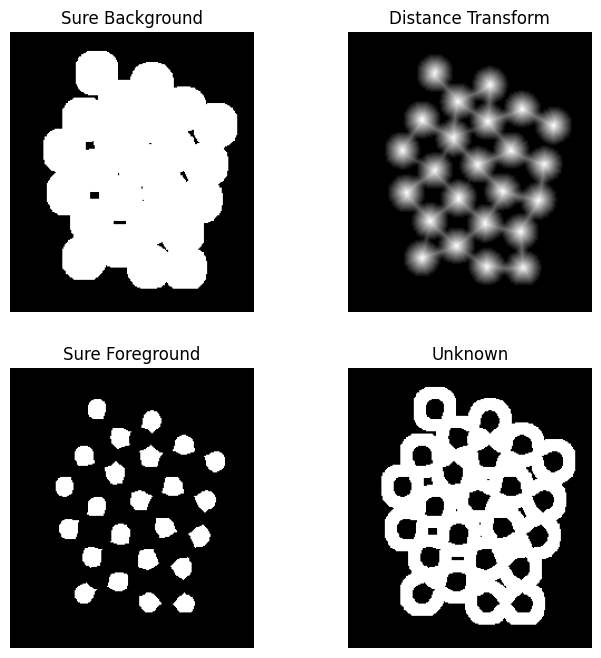

In [70]:
# Prepare markers: sure background, sure foreground, unknown
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
sure_bg = cv2.dilate(bin_img, kernel, iterations=3)
imshow(sure_bg, axes[0,0])
axes[0, 0].set_title('Sure Background')
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
imshow(dist, axes[0,1])
axes[0, 1].set_title('Distance Transform')
ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
imshow(sure_fg, axes[1,0])
axes[1, 0].set_title('Sure Foreground')
unknown = cv2.subtract(sure_bg, sure_fg)
imshow(unknown, axes[1,1])
axes[1, 1].set_title('Unknown')
plt.show()
# Save the markers figure reliably
fig.savefig(os.path.join(outputs_folder, '05_markers.png'), bbox_inches='tight')
plt.close(fig)


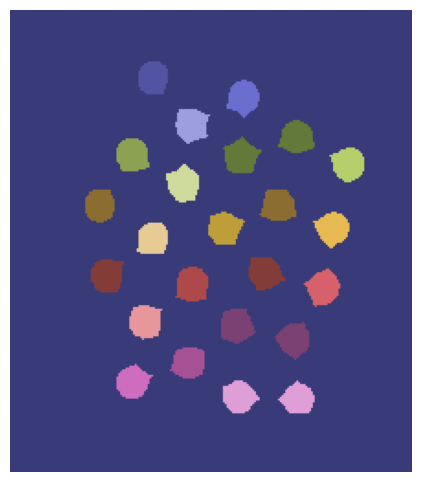

In [71]:
# Label markers
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()
fig.savefig(os.path.join(outputs_folder, '06_labeled_markers.png'), bbox_inches='tight')
plt.close(fig)


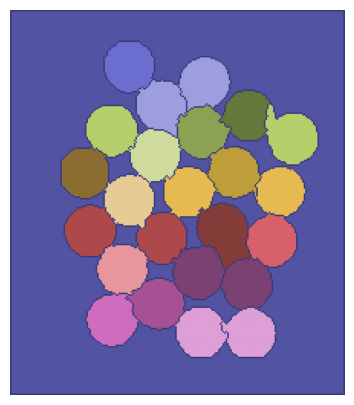

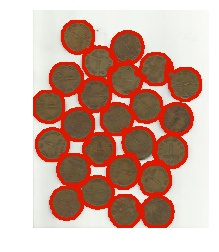

In [72]:
# Apply watershed and draw contours
markers = cv2.watershed(img, markers)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()
fig.savefig(os.path.join(outputs_folder, '07_watershed_markers.png'), bbox_inches='tight')
plt.close(fig)

labels = np.unique(markers)
coins = []
for label in labels[2:]:
    target = np.where(markers == label, 255, 0).astype(np.uint8)
    contours, _ = cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        coins.append(contours[0])
img_out = cv2.drawContours(img.copy(), coins, -1, color=(0, 23, 223), thickness=2)
imshow(img_out)
save_image(outputs_folder, '08_watershed_contours.png', img_out)
